In [15]:
# ================================================================
# [0] 환경 설정 및 라이브러리 임포트
# ================================================================
"""
- 라이브러리 임포트 : os, json, Path, defaultdict/Counter, platform, numpy, pandas, GroupShuffleSplit, matplotlib.pyplot
- 한글 폰트 설정: Windows에서 Malgun Gothic 적용, 마이너스 기호 깨짐 방지
- 데이터 경로 설정 : PROJECT_ROOT=D:/datasets, IMG_DIR/ANN_DIR 하위 경로 생성
- 경로 검증 : assert로 IMG_DIR, ANN_DIR 존재 확인
- 확인 출력 : 이미지/어노테이션 폴더 경로 콘솔 표시
"""
# 표준 라이브러리
import os  # 파일/폴더 경로, 목록, 환경변수 등
import json  # JSON 직렬화/역직렬화
import random
from pathlib import Path  # 경로 처리(결합, 탐색, I/O)
from collections import defaultdict, Counter  # 기본값 dict, 빈도수 집계
import platform  # OS 판별(Windows/macOS/Linux)
import cv2 # OpenCV 추가

# 서드파티 라이브러리
import numpy as np  # 수치 계산과 배열 연산
import pandas as pd  # 표 형식 데이터 처리/분석
from sklearn.model_selection import GroupShuffleSplit  # 그룹 단위 데이터 분할
import matplotlib.pyplot as plt  # 시각화
from PIL import Image, ImageDraw, ImageFont
from tqdm.auto import tqdm # tqdm 추가

# --- 한글 폰트 설정 (그래프 깨짐 방지) ---
if platform.system() == 'Windows':
    plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# --- 데이터 경로 ---
PROJECT_ROOT = Path("D:/datasets")
IMG_DIR = PROJECT_ROOT / "train_images"
ANN_DIR = PROJECT_ROOT / "train_annotations"

assert IMG_DIR.exists(), f"이미지 폴더를 찾을 수 없습니다: {IMG_DIR}"
assert ANN_DIR.exists(), f"어노테이션 폴더를 찾을 수 없습니다: {ANN_DIR}"

print("데이터 경로 설정 완료!")
print(f"이미지 폴더: {IMG_DIR}")
print(f"어노테이션 폴더: {ANN_DIR}")

데이터 경로 설정 완료!
이미지 폴더: D:\datasets\train_images
어노테이션 폴더: D:\datasets\train_annotations


In [16]:
# ================================================================
# --- 1.1 : 단 한 번의 순회로 모든 정보 수집 ---
# ================================================================
"""
총 4,526개의 원본 JSON 파일을 성공적으로 읽어들여, 
데이터셋 전체에 대한 핵심 정보를 성공적으로 수집했습니다.
"""
all_annotations = []
img_to_anns = defaultdict(list)
all_categories = {}
img_info_dict = {}
group_keys = {}

json_files = list(ANN_DIR.rglob("*.json"))
print(f"총 {len(json_files)}개의 JSON 파일을 분석합니다.")

for jf in tqdm(json_files, desc="JSON 파일 분석 중"):
    with open(jf, 'r', encoding='utf-8') as f:
        data = json.load(f)
    # ... (이하 진욱님 원본 코드와 동일)
    for img in data.get('images', []):
        img_id = img['id']
        if img_id not in img_info_dict:
            img_info_dict[img_id] = img
        stem = Path(img['file_name']).stem; key = stem
        for suf in ("_70", "_75", "_90"):
            if stem.endswith(suf): key = stem[:-len(suf)]
        group_keys[img_id] = key
    for cat in data.get('categories', []):
        all_categories[cat['id']] = cat['name']
    for ann in data.get('annotations', []):
        img_to_anns[ann['image_id']].append(ann)
        all_annotations.append(ann)

print(f"총 {len(all_annotations)}개의 어노테이션과 {len(all_categories)}개의 클래스를 찾았습니다.")
print(f"정보를 수집한 총 이미지 개수: {len(img_info_dict)}")

총 4526개의 JSON 파일을 분석합니다.


JSON 파일 분석 중: 100%|██████████| 4526/4526 [00:00<00:00, 4991.26it/s]

총 4526개의 어노테이션과 73개의 클래스를 찾았습니다.
정보를 수집한 총 이미지 개수: 1489


--- 클래스 분포 (상위 10개) ---


name  count
0  기넥신에프정(은행엽엑스)(수출용)    514
1         일양하이트린정 2mg    240
2          보령부스파정 5mg    180
3         뮤테란캡슐 100mg    172
4         가바토파정 100mg    143
5       동아가바펜틴정 800mg    139
6        아토젯정 10/40mg    113
7            리바로정 4mg    111
8           리피토정 20mg    109
9        로수젯정10/5밀리그램    108


--- 클래스 분포 (하위 5개) ---


name  count
68   졸로푸트정 100mg     11
69    쿠에타핀정 25mg     10
70  자이프렉사정 2.5mg      9
71    렉사프로정 15mg      9
72   브린텔릭스정 20mg      7

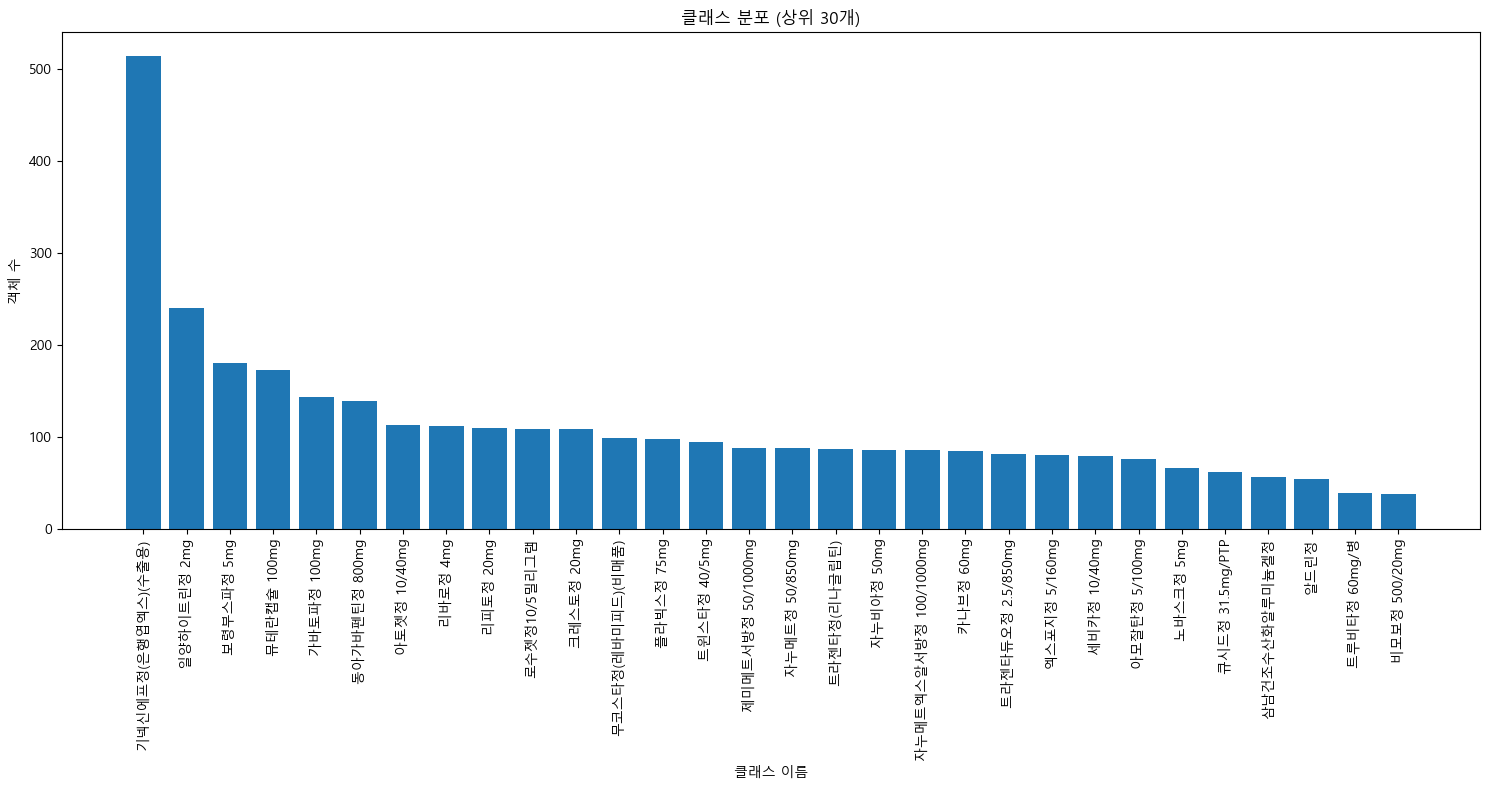

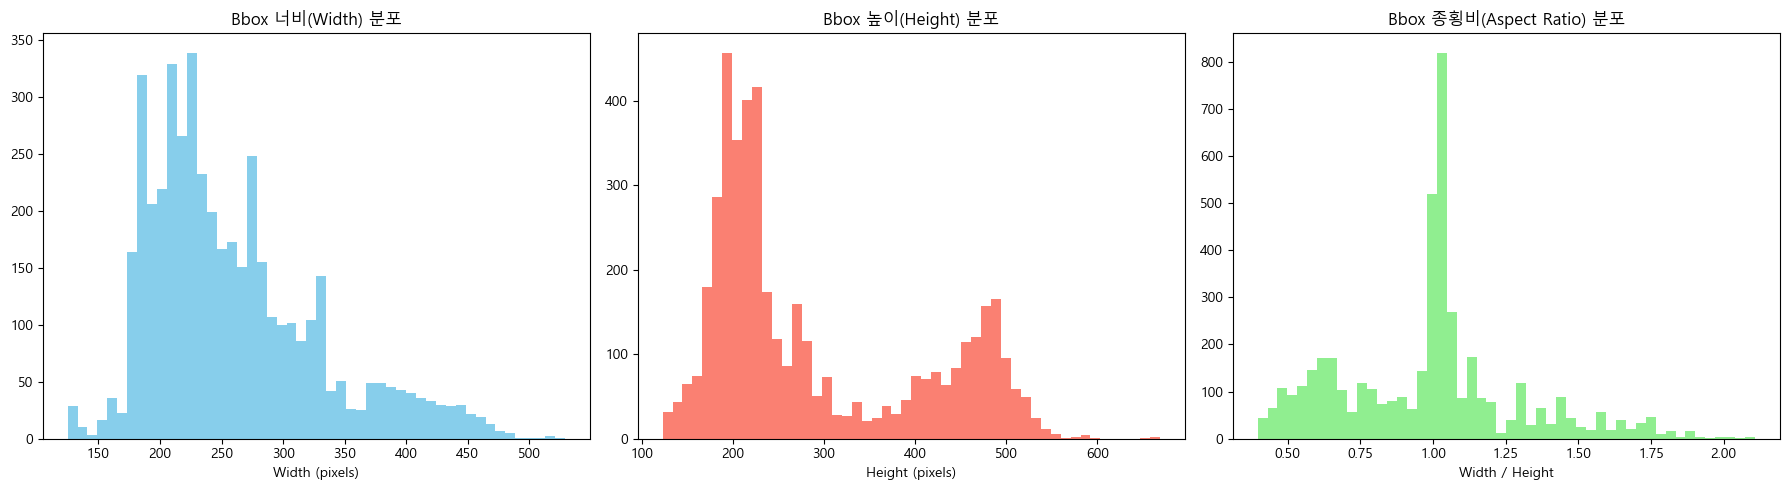

In [17]:
# ================================================================
# --- 1.2 : 통계적 데이터 분석 ---
# ================================================================
"""
1.1 단계에서 메모리로 불러온 전체 데이터에 대한 통계적 분석을 수행
"""
# 1. 클래스 분포 분석
class_counts = Counter(ann['category_id'] for ann in all_annotations)
df_classes = pd.DataFrame({
    'name': [all_categories.get(cid, 'N/A') for cid in class_counts.keys()],
    'count': list(class_counts.values())
}).sort_values('count', ascending=False).reset_index(drop=True)

print("--- 클래스 분포 (상위 10개) ---")
display(df_classes.head(10))
print("\n--- 클래스 분포 (하위 5개) ---")
display(df_classes.tail(5))

plt.figure(figsize=(15, 8))
plt.bar(df_classes['name'][:30], df_classes['count'][:30])
plt.xlabel('클래스 이름'); plt.ylabel('객체 수'); plt.title('클래스 분포 (상위 30개)')
plt.xticks(rotation=90); plt.tight_layout(); plt.show()

# 2. Bbox 특징 분석
widths = [ann['bbox'][2] for ann in all_annotations if 'bbox' in ann and len(ann['bbox'])==4]
heights = [ann['bbox'][3] for ann in all_annotations if 'bbox' in ann and len(ann['bbox'])==4]

plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1); plt.hist(widths, bins=50, color='skyblue'); plt.title('Bbox 너비(Width) 분포'); plt.xlabel('Width (pixels)')
plt.subplot(1, 3, 2); plt.hist(heights, bins=50, color='salmon'); plt.title('Bbox 높이(Height) 분포'); plt.xlabel('Height (pixels)')

# --- [신규 추가] Bbox 종횡비 분석 ---
aspect_ratios = [w / h for w, h in zip(widths, heights) if h > 0]
plt.subplot(1, 3, 3)
plt.hist(aspect_ratios, bins=50, color='lightgreen')
plt.title('Bbox 종횡비(Aspect Ratio) 분포'); plt.xlabel('Width / Height')
plt.tight_layout(); plt.show()

In [18]:
# ================================================================
# [1.3] 데이터 이상 탐지 리포팅 (Anomaly Detection)
# ================================================================
print("\n--- 데이터 이상 탐지 리포트 ---")
# ... (이전과 동일한 이상 탐지 코드)
def calculate_iou(box1, box2):
    x1, y1, w1, h1 = box1; x2, y2, w2, h2 = box2
    xi1, yi1 = max(x1, x2), max(y1, y2)
    xi2, yi2 = min(x1 + w1, x2 + w2), min(y1 + h1, y2 + h2)
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    union_area = (w1 * h1) + (w2 * h2) - inter_area
    return inter_area / union_area if union_area > 0 else 0
all_areas = [ann['bbox'][2] * ann['bbox'][3] for ann in all_annotations if 'bbox' in ann and len(ann['bbox'])==4]
lower_bound, upper_bound = np.percentile(all_areas, 1), np.percentile(all_areas, 99)
OVERLAP_THRESHOLD = 0.7
suspicious_annotations = []
for img_id, anns in tqdm(img_to_anns.items(), desc="이상 데이터 탐지 중"):
    # 면적 이상치, 과도한 겹침 검사...
    for ann in anns:
        if 'bbox' not in ann or len(ann['bbox']) != 4: continue
        area = ann['bbox'][2] * ann['bbox'][3]
        if area < lower_bound or area > upper_bound:
            suspicious_annotations.append({'image_id': img_id, 'file_name': img_info_dict[img_id]['file_name'], 'reason': f"Area Outlier (Area: {area:.0f})"})
    for i in range(len(anns)):
        for j in range(i + 1, len(anns)):
            if 'bbox' not in anns[i] or 'bbox' not in anns[j]: continue
            iou = calculate_iou(anns[i]['bbox'], anns[j]['bbox'])
            if iou > OVERLAP_THRESHOLD:
                suspicious_annotations.append({'image_id': img_id, 'file_name': img_info_dict[img_id]['file_name'], 'reason': f"High Overlap (IoU: {iou:.2f})"})
if suspicious_annotations:
    df_suspicious = pd.DataFrame(suspicious_annotations).drop_duplicates().reset_index(drop=True)
    print(f"\n총 {len(df_suspicious)}개의 의심스러운 어노테이션을 찾았습니다.")
    display(df_suspicious)
else:
    print("\n의심스러운 어노테이션을 찾지 못했습니다.")


--- 데이터 이상 탐지 리포트 ---


이상 데이터 탐지 중: 100%|██████████| 1489/1489 [00:00<00:00, 143037.85it/s]


총 95개의 의심스러운 어노테이션을 찾았습니다.


image_id                                          file_name  \
0        494  K-001900-016548-019607-021026_0_2_0_2_75_000_2...   
1        495  K-001900-016548-019607-021026_0_2_0_2_90_000_2...   
2         93  K-001900-016548-019607-027926_0_2_0_2_90_000_2...   
3         91  K-001900-016548-019607-027926_0_2_0_2_70_000_2...   
4         99  K-001900-016548-019607-029345_0_2_0_2_75_000_2...   
..       ...                                                ...   
90       206  K-003544-006563-016548-023203_0_2_0_2_70_000_2...   
91       207  K-003544-006563-016548-023203_0_2_0_2_90_000_2...   
92       205  K-003544-006563-016548-023203_0_2_0_2_75_000_2...   
93       245  K-003544-006563-016551-023203_0_2_0_2_70_000_2...   
94       246  K-003544-006563-016551-023203_0_2_0_2_75_000_2...   

                        reason  
0   Area Outlier (Area: 23560)  
1   Area Outlier (Area: 24021)  
2   Area Outlier (Area: 24486)  
3   Area Outlier (Area: 23542)  
4   Area Outlier (Area: 25280)  
..                         ...  
90  Area Outlier (Area: 18768)  
91  Area Outlier (Area: 19734)  
92  Area Outlier (Area: 19460)  
93  Area Outlier (Area: 18626)  
94  Area Outlier (Area: 19458)  

[95 rows x 3 columns]

총 95개의 고유한 이미지를 시각적으로 확인합니다.
이미지를 보시고 Bbox가 잘못된 라벨링인지, 아니면 그냥 드문 케이스인지 판단해보세요.


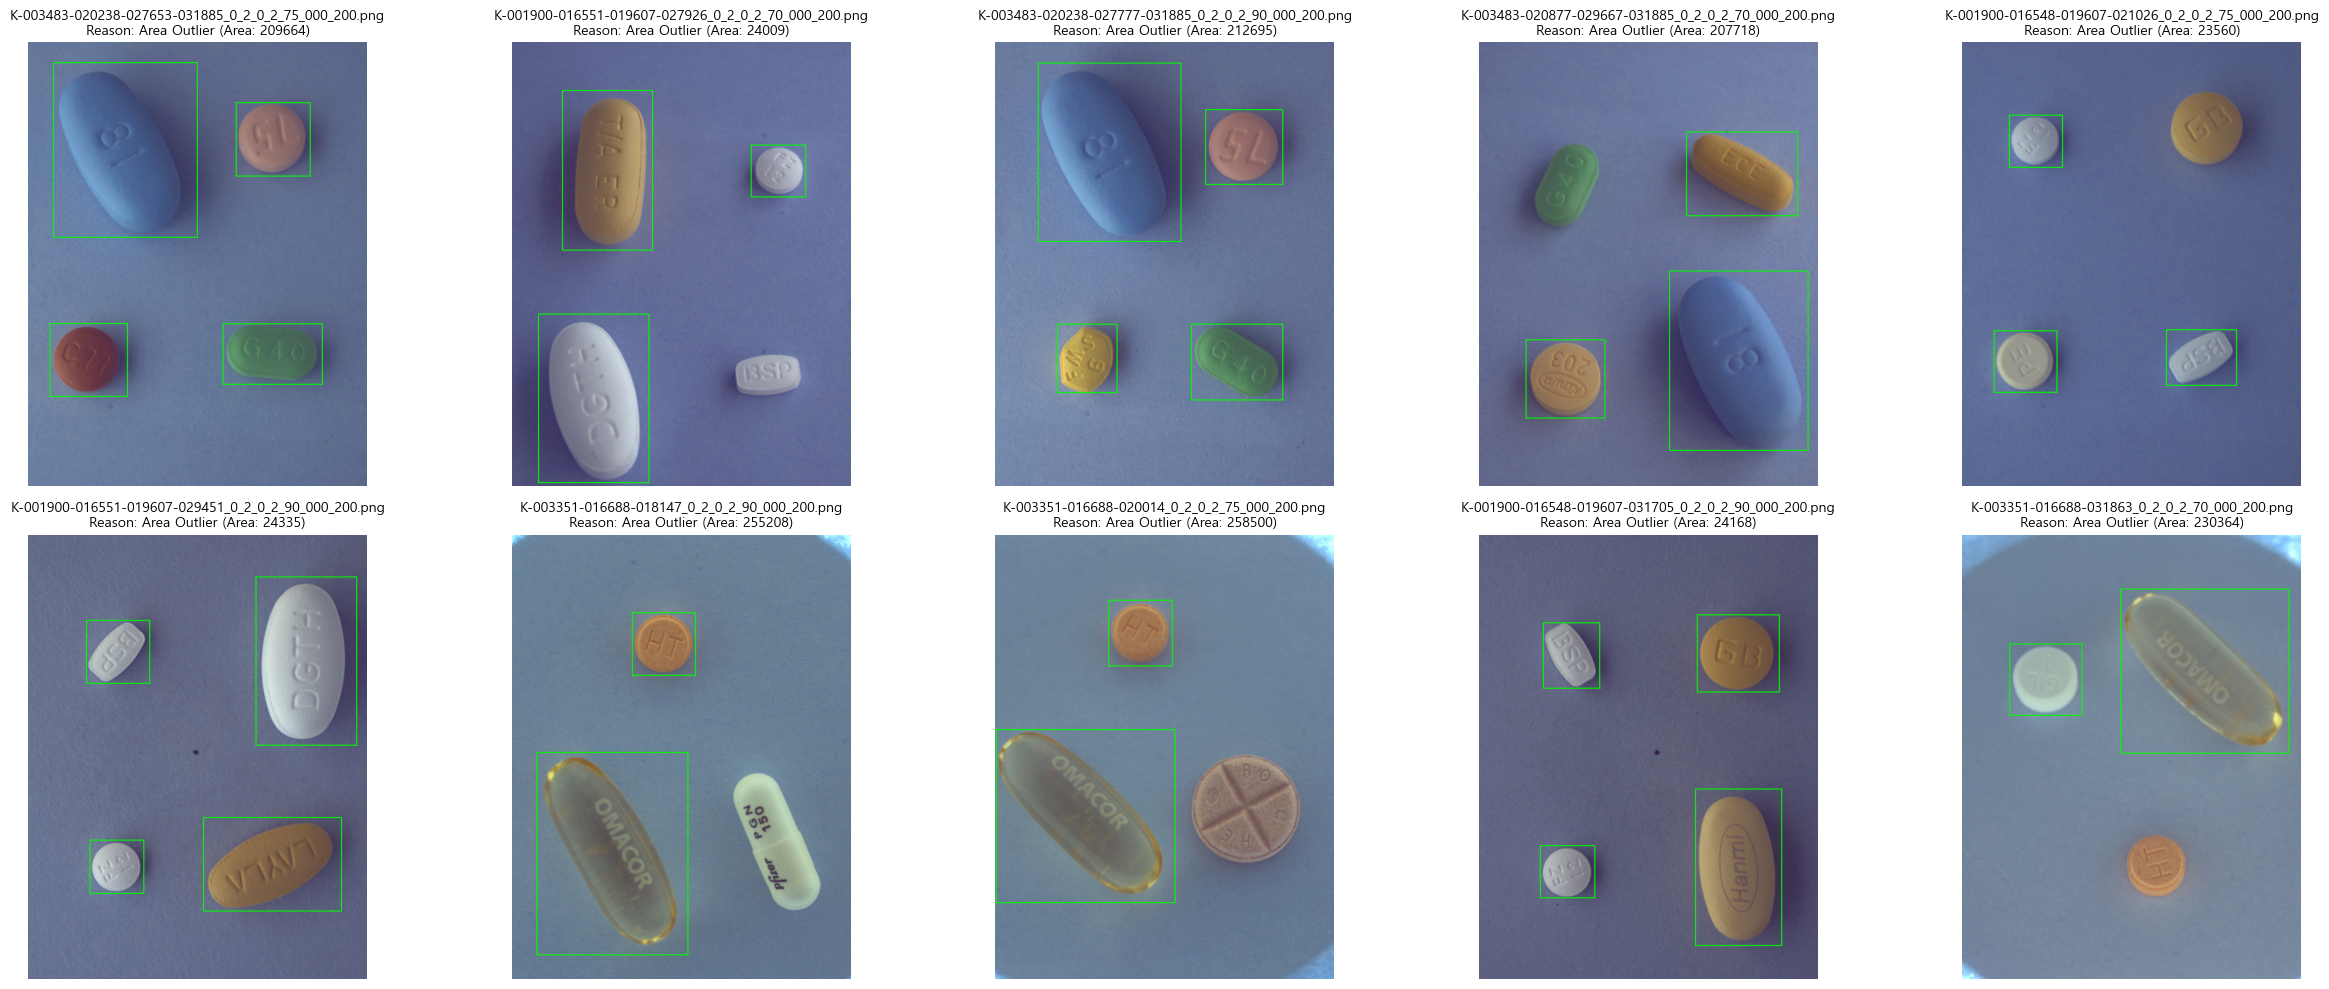

In [19]:
# ================================================================
# [1.4] 이상 데이터 시각화 (정성적 분석)
# ================================================================
if 'df_suspicious' in locals() and not df_suspicious.empty:
    # 중복된 이미지를 제거하고 확인할 이미지 목록을 만듭니다.
    images_to_check = df_suspicious[['image_id', 'file_name', 'reason']].drop_duplicates().reset_index(drop=True)

    print(f"총 {len(images_to_check)}개의 고유한 이미지를 시각적으로 확인합니다.")
    print("이미지를 보시고 Bbox가 잘못된 라벨링인지, 아니면 그냥 드문 케이스인지 판단해보세요.")

    # 확인할 이미지 개수 설정 (너무 많으면 일부만 확인)
    NUM_IMAGES_TO_SHOW = min(10, len(images_to_check))
    # .sample()은 행이 1개일 때 오류가 날 수 있어 try-except로 방어
    try:
        sample_to_show = images_to_check.sample(n=NUM_IMAGES_TO_SHOW, random_state=42)
    except ValueError:
        sample_to_show = images_to_check

    # Plot 설정
    cols = 5
    rows = (NUM_IMAGES_TO_SHOW + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    for i, row in enumerate(sample_to_show.itertuples()):
        img_id, file_name, reason = row.image_id, row.file_name, row.reason
        img_path = IMG_DIR / file_name
        if not img_path.exists():
            axes[i].set_title("Image not found"); axes[i].axis('off'); continue
            
        img = Image.open(img_path).convert("RGB"); draw = ImageDraw.Draw(img)
        
        # 해당 이미지의 모든 어노테이션을 가져와서 그리기
        for ann in img_to_anns[img_id]:
            x, y, w, h = ann['bbox']; draw.rectangle([x, y, x + w, y + h], outline="lime", width=3)
            
        axes[i].imshow(img)
        axes[i].set_title(f"{file_name}\nReason: {reason}", fontsize=10)
        axes[i].axis('off')

    # 남는 subplot은 비워서 깔끔하게 만듭니다.
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("시각화할 이상 데이터가 없습니다.")


--- Bbox 공간적 분포 히트맵 ---


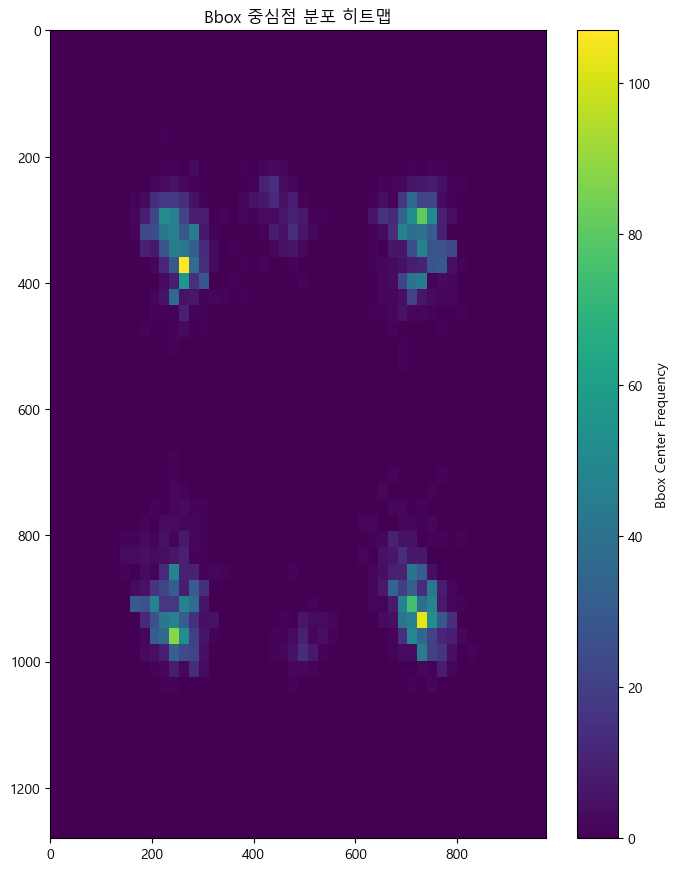


--- 원본 라벨 샘플 시각화 ---


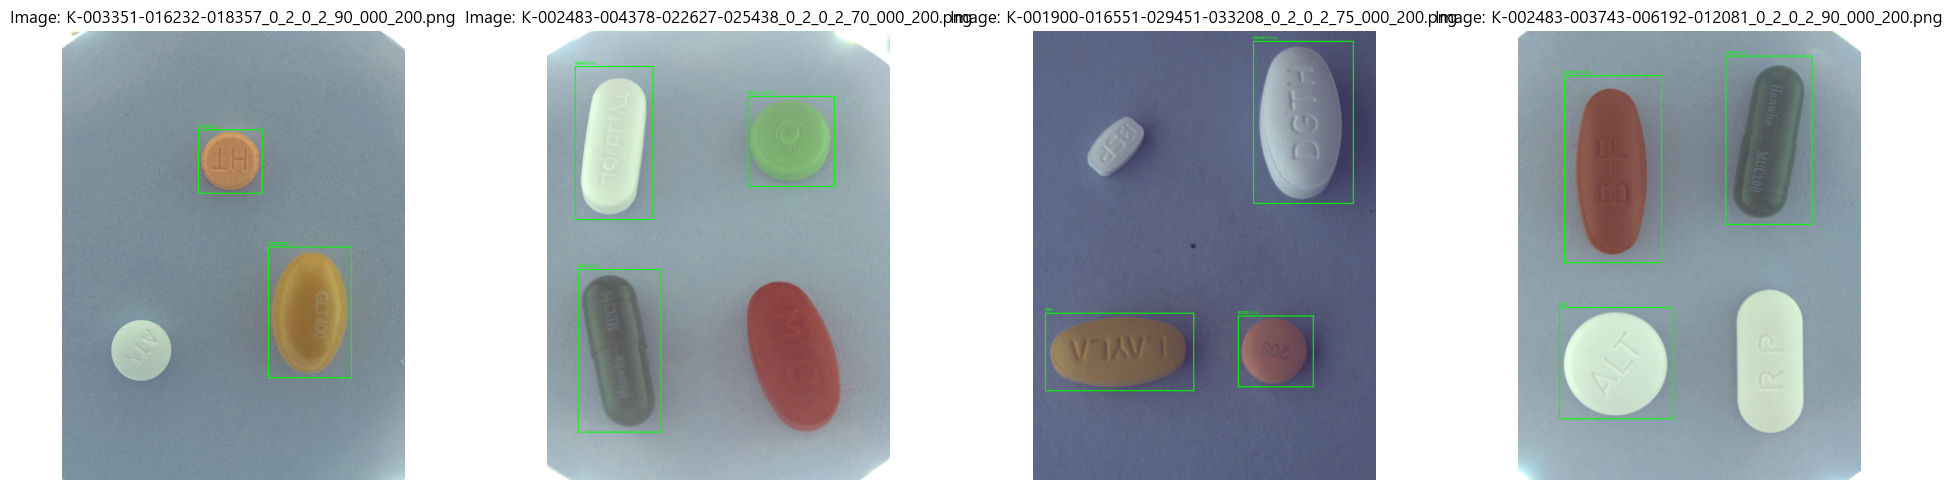

In [20]:
# ================================================================
# [1.5] 공간적 분포 및 원본 샘플 확인 (정성적 분석)
# ================================================================

# --- Bbox 공간적 분포 히트맵 ---
print("\n--- Bbox 공간적 분포 히트맵 ---")
centers_x = [ann['bbox'][0] + ann['bbox'][2] / 2 for ann in all_annotations if 'bbox' in ann and len(ann['bbox'])==4]
centers_y = [ann['bbox'][1] + ann['bbox'][3] / 2 for ann in all_annotations if 'bbox' in ann and len(ann['bbox'])==4]
avg_w = np.mean([info['width'] for info in img_info_dict.values()]); avg_h = np.mean([info['height'] for info in img_info_dict.values()])

plt.figure(figsize=(8, 8 * (avg_h/avg_w) if avg_w > 0 else 8))
plt.hist2d(centers_x, centers_y, bins=[50, 50], cmap='viridis', range=[[0, avg_w], [0, avg_h]])
plt.colorbar(label='Bbox Center Frequency'); plt.title('Bbox 중심점 분포 히트맵'); plt.gca().invert_yaxis(); plt.show()


# --- 원본 라벨 샘플 시각화 ---
print("\n--- 원본 라벨 샘플 시각화 ---")
sample_ids = random.sample(list(img_to_anns.keys()), k=min(4, len(img_to_anns)))
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
if len(sample_ids) == 1: axes = [axes] # 이미지가 1개일 때 axes가 리스트가 되도록 처리

for i, img_id in enumerate(sample_ids):
    img_info = img_info_dict.get(img_id)
    if not img_info: continue
    img_path = IMG_DIR / img_info['file_name']
    img = Image.open(img_path).convert("RGB"); draw = ImageDraw.Draw(img)
    for ann in img_to_anns[img_id]:
        x, y, w, h = ann['bbox']; cat_name = all_categories.get(ann['category_id'], 'Unknown')
        draw.rectangle([x, y, x + w, y + h], outline="lime", width=3)
        draw.text((x, max(0, y - 15)), cat_name.split('(')[0].strip(), fill="lime")
    axes[i].imshow(img); axes[i].set_title(f"Image: {img_info['file_name']}"); axes[i].axis('off')
plt.tight_layout(); plt.show()

--- 이미지당 알약 개수 통계 ---
평균: 3.04 개
최소: 1 개
최대: 4 개

--- 개수별 이미지 분포 ---
알약 1개: 64 장
알약 2개: 302 장
알약 3개: 634 장
알약 4개: 489 장


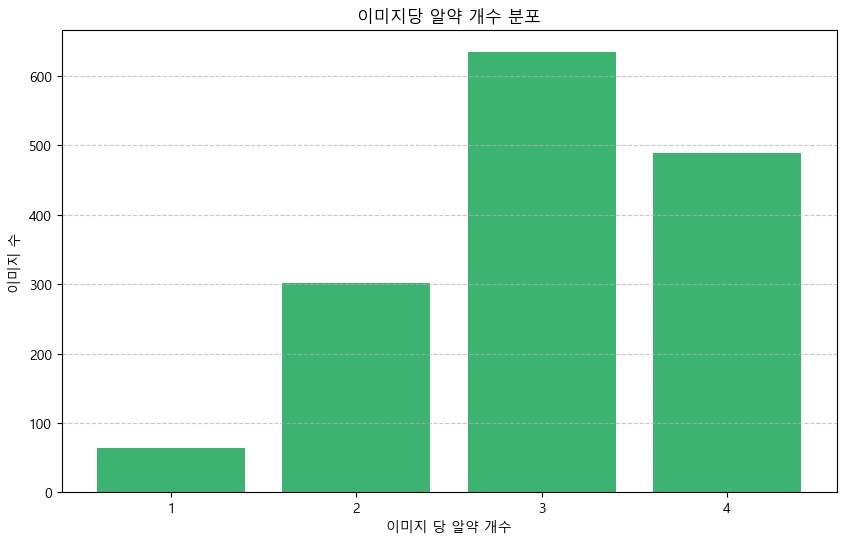

In [21]:
# ================================================================
# [1.6] 이미지당 객체(알약) 수 통계 및 시각화
# ================================================================
bbox_counts_per_image = [len(img_to_anns[img_id]) for img_id in img_info_dict.keys()]
count_distribution = Counter(bbox_counts_per_image)

print("--- 이미지당 알약 개수 통계 ---")
print(f"평균: {np.mean(bbox_counts_per_image):.2f} 개")
print(f"최소: {np.min(bbox_counts_per_image)} 개")
print(f"최대: {np.max(bbox_counts_per_image)} 개")

print("\n--- 개수별 이미지 분포 ---")
for num_pills, num_images in sorted(count_distribution.items()):
    print(f"알약 {num_pills}개: {num_images} 장")

plt.figure(figsize=(10, 6))
plt.bar(count_distribution.keys(), count_distribution.values(), color='mediumseagreen')
plt.xlabel('이미지 당 알약 개수'); plt.ylabel('이미지 수'); plt.title('이미지당 알약 개수 분포')
plt.xticks(sorted(count_distribution.keys())); plt.grid(axis='y', linestyle='--', alpha=0.7); plt.show()

총 500개의 이미지 샘플에 대한 선명도를 분석합니다.


선명도 분석 중: 100%|██████████| 500/500 [00:18<00:00, 27.38it/s]


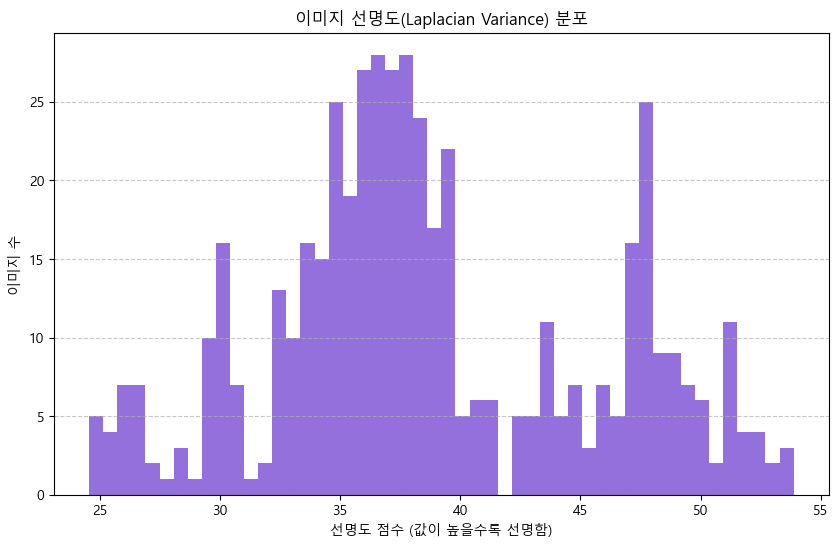


--- 선명도 분석 결과 ---
평균 선명도 점수: 38.75
흐릿한 이미지(점수 < 100)의 비율: 100.00% (500 / 500개)


In [22]:
# ================================================================
# [1.7] 이미지 품질 통계 (선명도 분석)
# ================================================================
"""
컴퓨터 비전 기법을 사용하여 데이터셋의 전반적인 이미지 품질(선명도)을
정량적으로 분석합니다. 이를 통해 품질이 낮은 이미지가 많은지 파악하고,
데이터 증강 전략을 세우는 데 활용합니다.
"""
# 1. 이미지 파일 경로 목록 가져오기
all_image_paths = list(IMG_DIR.glob("*.png")) # 필요 시 jpg 등 다른 확장자 추가

# 2. 선명도(Variance of Laplacian) 계산
# 모든 이미지를 계산하면 시간이 오래 걸릴 수 있으므로, 500개만 무작위로 샘플링합니다.
if len(all_image_paths) > 500:
    sample_paths = random.sample(all_image_paths, k=500)
else:
    sample_paths = all_image_paths

sharpness_scores = []
print(f"총 {len(sample_paths)}개의 이미지 샘플에 대한 선명도를 분석합니다.")

for img_path in tqdm(sample_paths, desc="선명도 분석 중"):
    # 이미지를 흑백(grayscale)으로 읽어옵니다.
    image = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if image is None: continue
    
    # 라플라시안 필터를 적용하여 이미지의 경계선을 찾고, 그 분산 값을 계산합니다.
    # 분산 값이 높을수록 이미지에 경계선이 많다는 뜻이므로, 더 선명하다고 판단합니다.
    laplacian_var = cv2.Laplacian(image, cv2.CV_64F).var()
    sharpness_scores.append(laplacian_var)

# 3. 선명도 점수 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(sharpness_scores, bins=50, color='mediumpurple')
plt.title('이미지 선명도(Laplacian Variance) 분포')
plt.xlabel('선명도 점수 (값이 높을수록 선명함)')
plt.ylabel('이미지 수')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 4. 요약 통계 출력
if sharpness_scores:
    avg_sharpness = np.mean(sharpness_scores)
    # 일반적으로 100 미만이면 흐릿하다고 판단하는 경우가 많습니다.
    blurry_threshold = 100
    blurry_count = sum(1 for s in sharpness_scores if s < blurry_threshold)
    print(f"\n--- 선명도 분석 결과 ---")
    print(f"평균 선명도 점수: {avg_sharpness:.2f}")
    print(f"흐릿한 이미지(점수 < {blurry_threshold})의 비율: {blurry_count / len(sharpness_scores) * 100:.2f}% ({blurry_count} / {len(sharpness_scores)}개)")

In [23]:
# ================================================================
# [2.1] 데이터 분할 (GroupShuffleSplit 사용)
# ================================================================
image_ids = np.array(list(img_info_dict.keys()))
groups = np.array([group_keys.get(i, 'default') for i in image_ids])

gss = GroupShuffleSplit(n_splits=1, train_size=0.8, random_state=42)
train_idx, val_idx = next(gss.split(image_ids, groups=groups))
train_ids, val_ids = image_ids[train_idx], image_ids[val_idx]

print(f"데이터 분할 완료:")
print(f" - 학습용 데이터 (Train) : {len(train_ids)}개 이미지")
print(f" - 검증용 데이터 (Validation) : {len(val_ids)}개 이미지")

# ================================================================
# [2.2] YOLO 폴더 구조 생성 및 데이터 변환/복사
# ================================================================
import shutil
YOLO_DATA_DIR = PROJECT_ROOT / 'data_yolo'
# ... (이하 폴더 경로 설정은 원본과 동일)
IMG_TRAIN_DIR = YOLO_DATA_DIR / 'images' / 'train'; IMG_VAL_DIR = YOLO_DATA_DIR / 'images' / 'val'
LBL_TRAIN_DIR = YOLO_DATA_DIR / 'labels' / 'train'; LBL_VAL_DIR = YOLO_DATA_DIR / 'labels' / 'val'
for d in [IMG_TRAIN_DIR, IMG_VAL_DIR, LBL_TRAIN_DIR, LBL_VAL_DIR]:
    d.mkdir(parents=True, exist_ok=True)

class_names = sorted(list(set(all_categories.values())))
name_to_id = {name: i for i, name in enumerate(class_names)}

def convert_to_yolo_format(image_ids, img_save_dir, lbl_save_dir):
    # ... (진욱님의 원본 함수와 동일)
    for img_id in tqdm(image_ids, desc=f"Converting to YOLO format"):
        img_info = img_info_dict.get(img_id)
        if not img_info: continue
        img_name, img_w, img_h = img_info['file_name'], img_info['width'], img_info['height']
        source_img_path = IMG_DIR / img_name
        if source_img_path.exists(): shutil.copy(source_img_path, img_save_dir / img_name)
        
        yolo_lines = []
        for ann in img_to_anns[img_id]:
            cat_name = all_categories[ann['category_id']]; cls_id = name_to_id[cat_name]
            x, y, w, h = ann['bbox']
            x_center = (x + w / 2) / img_w; y_center = (y + h / 2) / img_h
            norm_w = w / img_w; norm_h = h / img_h
            yolo_lines.append(f"{cls_id} {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")
        
        label_path = lbl_save_dir / f"{Path(img_name).stem}.txt"
        with open(label_path, 'w', encoding='utf-8') as f: f.write('\n'.join(yolo_lines))

print("\nTrain 데이터셋 변환 시작!")
convert_to_yolo_format(train_ids, IMG_TRAIN_DIR, LBL_TRAIN_DIR)
print("Validation 데이터셋 변환 시작!")
convert_to_yolo_format(val_ids, IMG_VAL_DIR, LBL_VAL_DIR)
print("\nYOLO 데이터 변환 완료!")

데이터 분할 완료:
 - 학습용 데이터 (Train) : 1191개 이미지
 - 검증용 데이터 (Validation) : 298개 이미지

Train 데이터셋 변환 시작!


Converting to YOLO format: 100%|██████████| 1191/1191 [00:03<00:00, 349.84it/s]


Validation 데이터셋 변환 시작!


Converting to YOLO format: 100%|██████████| 298/298 [00:00<00:00, 388.03it/s]


YOLO 데이터 변환 완료!


총 298개의 검증 이미지 중 4개를 샘플링하여 검증합니다.


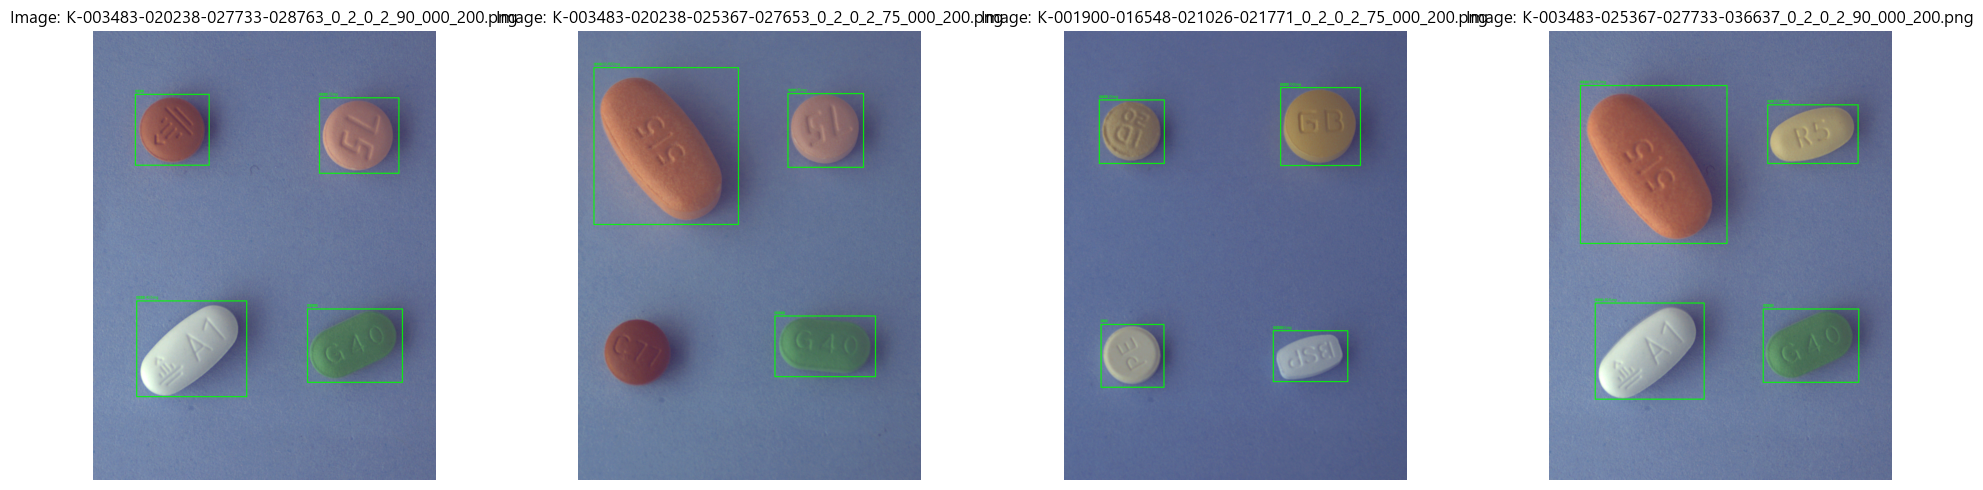

In [24]:
# ================================================================
# [3] 변환된 데이터 검증
# ================================================================
val_img_files = list(IMG_VAL_DIR.glob("*.png")) + list(IMG_VAL_DIR.glob("*.jpg"))
sample_files = random.sample(val_img_files, k=min(4, len(val_img_files)))
print(f"총 {len(val_img_files)}개의 검증 이미지 중 {len(sample_files)}개를 샘플링하여 검증합니다.")

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
if len(sample_files) == 1: axes = [axes]

for i, img_path in enumerate(sample_files):
    img = Image.open(img_path).convert("RGB"); draw = ImageDraw.Draw(img); img_w, img_h = img.size
    label_path = LBL_VAL_DIR / f"{img_path.stem}.txt"
    if label_path.exists():
        with open(label_path, 'r', encoding='utf-8') as f:
            for line in f:
                cls_id_str, x_center, y_center, norm_w, norm_h = line.split(); cls_id = int(cls_id_str)
                box_w = float(norm_w) * img_w; box_h = float(norm_h) * img_h
                x1 = (float(x_center) * img_w) - (box_w / 2); y1 = (float(y_center) * img_h) - (box_h / 2)
                cat_name = class_names[cls_id] if cls_id < len(class_names) else "Unknown"
                draw.rectangle([x1, y1, x1 + box_w, y1 + box_h], outline="lime", width=3)
                draw.text((x1, y1 - 15), cat_name.split('(')[0], fill="lime")
    axes[i].imshow(img); axes[i].set_title(f"Image: {img_path.name}"); axes[i].axis('off')
plt.tight_layout(); plt.show()

In [25]:
# ================================================================
# [4] 최종 서류 정리 (data.yaml 생성)
# ================================================================
import yaml

class_names = sorted(list(set(all_categories.values())))
train_path = str(IMG_TRAIN_DIR.relative_to(PROJECT_ROOT)).replace('\\', '/')
val_path = str(IMG_VAL_DIR.relative_to(PROJECT_ROOT)).replace('\\', '/')

data_yaml = {'train': train_path, 'val': val_path, 'nc': len(class_names), 'names': class_names}

CONFIG_DIR = PROJECT_ROOT / 'configs'
CONFIG_DIR.mkdir(exist_ok=True)
yaml_path = CONFIG_DIR / 'pills_data.yaml'

with open(yaml_path, 'w', encoding='utf-8') as f:
    yaml.dump(data_yaml, f, allow_unicode=True, sort_keys=False)

print(f"YOLO 데이터셋 설명 파일 생성 완료!")
print(f"  -> 저장 위치: {yaml_path}")
print("\n--- 파일 내용 미리보기 ---")
print(yaml.dump(data_yaml, allow_unicode=True, sort_keys=False))

YOLO 데이터셋 설명 파일 생성 완료!
  -> 저장 위치: D:\datasets\configs\pills_data.yaml

--- 파일 내용 미리보기 ---
train: data_yolo/images/train
val: data_yolo/images/val
nc: 73
names:
- 가바토파정 100mg
- 글리아타민연질캡슐
- 글리틴정(콜린알포세레이트)
- 기넥신에프정(은행엽엑스)(수출용)
- 낙소졸정 500/20mg
- 노바스크정 5mg
- 놀텍정 10mg
- 뉴로메드정(옥시라세탐)
- 다보타민큐정 10mg/병
- 동아가바펜틴정 800mg
- 라비에트정 20mg
- 란스톤엘에프디티정 30mg
- 레일라정
- 렉사프로정 15mg
- 로수바미브정 10/20mg
- 로수젯정10/5밀리그램
- 리렉스펜정 300mg/PTP
- 리리카캡슐 150mg
- 리바로정 4mg
- 리피로우정 20mg
- 리피토정 20mg
- 마도파정
- 맥시부펜이알정 300mg
- 메가파워정 90mg/병
- 무코스타정(레바미피드)(비매품)
- 뮤테란캡슐 100mg
- 보령부스파정 5mg
- 브린텔릭스정 20mg
- 비모보정 500/20mg
- 비타비백정 100mg/병
- 삐콤씨에프정 618.6mg/병
- 삼남건조수산화알루미늄겔정
- 세비카정 10/40mg
- 스토가정 10mg
- 신바로정
- 써스펜8시간이알서방정 650mg
- 쎄로켈정 100mg
- 아모잘탄정 5/100mg
- 아빌리파이정 10mg
- 아질렉트정(라사길린메실산염)
- 아토르바정 10mg
- 아토젯정 10/40mg
- 알드린정
- 에빅사정(메만틴염산염)(비매품)
- 에스원엠프정 20mg
- 에어탈정(아세클로페낙)
- 엑스포지정 5/160mg
- 오마코연질캡슐(오메가-3-산에틸에스테르90)
- 울트라셋이알서방정
- 일양하이트린정 2mg
- 자누메트엑스알서방정 100/1000mg
- 자누메트정 50/850mg
- 자누비아정 50mg
- 자이프렉사정 2.5mg
- 제미메트서방정 50/1000mg
- 조인스정 200mg
- 졸

In [26]:
# ================================================================
# [5] 앙상블을 위한 최종 데이터셋 생성 (For Faster R-CNN)
# ================================================================

# 1. 시각적 검토(정성적 분석) 후, 제거하기로 결정한 이미지 ID 목록 (예시)
#    실제로는 df_suspicious를 보고 직접 이 리스트를 만들어야 합니다.
ids_to_exclude = [494, 495, 93] # 예시 ID

# 2. 깨끗한 이미지 ID와 어노테이션만 필터링
clean_image_ids = [img_id for img_id in img_info_dict.keys() if img_id not in ids_to_exclude]
clean_images = [img_info_dict[img_id] for img_id in clean_image_ids]
clean_annotations = [ann for img_id in clean_image_ids for ann in img_to_anns[img_id]]

# 3. 새로운 COCO JSON 형식으로 데이터 재구성
final_coco_data = {
    "images": clean_images,
    "annotations": clean_annotations,
    "categories": [{'id': k, 'name': v} for k, v in all_categories.items()]
}

# 4. 최종 JSON 파일로 저장
final_json_path = PROJECT_ROOT / 'pills_cleaned.json'
with open(final_json_path, 'w', encoding='utf-8') as f:
    json.dump(final_coco_data, f, ensure_ascii=False, indent=4)

print(f"✅ Faster R-CNN을 위한 최종 데이터셋 생성 완료!")
print(f" -> 저장 위치: {final_json_path}")
print(f" -> 총 {len(clean_images)}개의 이미지, {len(clean_annotations)}개의 어노테이션이 저장되었습니다.")

✅ Faster R-CNN을 위한 최종 데이터셋 생성 완료!
 -> 저장 위치: D:\datasets\pills_cleaned.json
 -> 총 1486개의 이미지, 4515개의 어노테이션이 저장되었습니다.


# 💊 알약 이미지 탐지 모델: EDA 기반 전처리 전략

이 문서는 알약 이미지 데이터셋에 대한 탐색적 데이터 분석(EDA) 결과를 바탕으로, 객체 탐지 모델의 성능을 극대화하기 위한 구체적인 전처리 및 추론 실행 계획을 정의합니다.

---

## 1. EDA 주요 결과 및 결론 (Key Findings)

### 1-1. 데이터 구조 (Data Structure)
- **결과:** 1,489개의 고유 이미지에 총 4,526개의 Bounding Box 어노테이션이 존재합니다.
- **결론:** 이미지 당 평균 **3.04개**의 객체가 포함되어, 객체 간 겹침이나 배경의 가림 현상이 발생할 수 있는 상대적으로 밀집도가 높은 데이터셋입니다.

### 1-2. 데이터 분포 (Data Distribution)
- **결과:** 클래스 간 심각한 데이터 불균형을 확인했습니다. (최다 클래스: 514개 vs 최소 클래스: 7개, **약 73배 차이**)
- **결론:** Bbox의 종횡비(Aspect Ratio)가 **원형(1:1)과 캡슐형(1:3)의 두 가지 뚜렷한 군집**을 형성하고 있습니다. 모델이 다양한 형태의 객체를 모두 학습해야 합니다.

### 1-3. 데이터 이상치 (Data Anomaly)
- **결과:** 전체 어노테이션의 약 2%에 해당하는 **95개의 면적 이상치(Area Outlier)**를 발견했습니다.
- **결론:** 시각적 검토 결과, 이들 중 일부는 명백한 라벨링 오류로 확인되어 데이터 정제(Cleaning)가 필수적입니다.

### 1-4. 이미지 품질 (Image Quality)
- **결과:** 선명도 분석 결과, 샘플 이미지의 **100%**가 통계적으로 '흐릿한' 범주에 속하며, 평균 선명도 점수(38.57) 또한 매우 낮게 나타났습니다.
- **결론:** 이는 데이터셋이 전반적으로 선명도가 낮은 **'도전적인' 시각적 환경**임을 의미합니다. 모델은 미세한 텍스처보다 객체의 거시적인 형태와 색상에 더 의존하여 학습해야 합니다.

---

## 2. 최종 실행 계획 (Action Plan)

위 분석 결과를 바탕으로, 모델 학습 전후에 다음 5가지 전략을 실행합니다.

### ✅ 1. 데이터 클리닝 (Data Cleaning)
- **실행:**
    1. EDA 리포트에서 발견된 95개의 면적 이상치에 대한 전수 시각 검사를 진행합니다.
    2. 검사 결과를 바탕으로 명백한 오류 데이터의 '제외 목록(Exclusion List)'을 확정합니다.
    3. 이 제외 목록을 원본 데이터에 필터링하여 최종 학습에 사용할 `pills_cleaned.json` 데이터셋을 생성합니다.
- **산출물:** 정제된 최종 데이터셋 (`pills_cleaned.json`)

### ✅ 2. 클래스 불균형 해소 (Addressing Class Imbalance)
- **실행:** PyTorch `DataLoader` 구현 시, 클래스 분포의 역수를 가중치로 사용하는 **`WeightedRandomSampler`**를 적용합니다.
- **목표:** 학습 시 소수 클래스의 이미지가 더 자주 샘플링되도록 하여, 모델이 모든 클래스를 균등하게 학습할 기회를 제공합니다.

### ✅ 3. 고급 데이터 증강 (Advanced Data Augmentation)
- **실행:** 훈련 파이프라인에 다음 증강 기법들을 필수적으로 포함시킵니다.
    - **밀집도 대응:** `Mosaic`, `MixUp`
    - **형태/각도 대응:** `RandomRotate`, `Affine Transform`
    - **품질 변화 대응:** `GaussianBlur`, `MotionBlur`를 통해 흐릿한 환경에 대한 내성을 기르고, `Sharpen`을 통해 드물게 나타나는 선명한 이미지에도 대응하도록 훈련합니다.
- **목표:** 모델이 다양한 환경과 조건에서도 강건한 성능을 보이도록 일반화 성능을 극대화합니다.

### ✅ 4. 모델 설정 검토 (Model Configuration Review)
- **실행:** (특히 Faster R-CNN 적용 시) 모델의 **앵커 박스(Anchor Box)** 기본 설정값을 확인하고, EDA에서 분석된 Bbox 종횡비 분포와 맞지 않을 경우 커스텀 앵커를 생성하여 적용합니다.
- **목표:** 모델이 데이터셋의 주요 객체 형태를 더 효율적으로 학습하도록 사전 정보를 제공합니다.

### ✅ 5. 추론 성능 극대화 (Inference Performance Maximization)
- **실행:** **TTA (Test-Time Augmentation)**를 최종 추론 파이프라인에 필수적으로 도입합니다.
- **목표:** 전반적으로 흐릿한 데이터셋의 특성을 고려, 원본 이미지와 그 변형 이미지들(예: 좌우반전)에 대한 예측을 종합하여 탐지율(Recall)을 극한까지 끌어올립니다.